#Defining the Problem

Here we will derive the equations of motion for the classic mass-spring-damper system under the influence of gravity. The following figure gives a pictorial description of the problem.

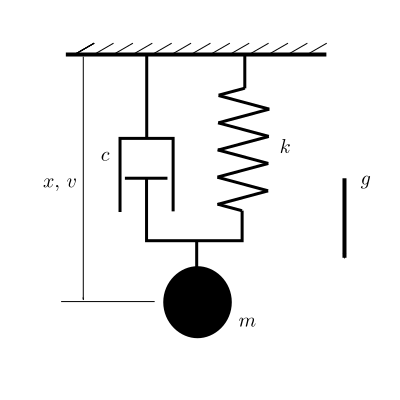

In [152]:
from IPython.display import SVG
SVG(filename='mass_spring_damper.svg')

Start by loading in the core functionality of both SymPy and Mechanics.

In [153]:
import sympy as sym
import sympy.physics.mechanics as me

We can make use of the pretty printing of our results by loading SymPy's printing extension, in particular we will use the vector printing which is nice for mechanics objects.

In [154]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax')

We'll start by defining the variables we will need for this problem:
- $x(t)$: distance of the particle from the ceiling
- $v(t)$: speed of the particle
- $m$: mass of the particle
- $c$: damping coefficient of the damper
- $k$: stiffness of the spring
- $g$: acceleration due to gravity
- $t$: time

In [155]:
x, v = me.dynamicsymbols('x v')

In [156]:
m, c, k, g, t = sym.symbols('m c k g t')

Now, we define a Newtonian reference frame that represents the ceiling which the particle is attached to, $C$.

In [157]:
ceiling = me.ReferenceFrame('C')

We will need two points, one to represent the original position of the particle which stays fixed in the ceiling frame, $O$, and the second one, $P$ which is aligned with the particle as it moves.

In [158]:
O = me.Point('O')
P = me.Point('P')

The velocity of point $O$ in the ceiling is zero.

In [159]:
O.set_vel(ceiling, 0)

Point $P$ can move downward in the $y$ direction and its velocity is specified as $v$ in the downward direction.

In [160]:
P.set_pos(O, x * ceiling.x)
P.set_vel(ceiling, v * ceiling.x)
P.vel(ceiling)

v c_x

There are three forces acting on the particle. Those due to the acceleration of gravity, the damper, and the spring.

In [161]:
damping = -c * P.vel(ceiling)
stiffness = -k * P.pos_from(O)
gravity = m * g * ceiling.x
forces = damping + stiffness + gravity
forces

(-c⋅v + g⋅m - k⋅x) c_x

Now we can use Newton's second law, $0=F-ma$, to form the equation of motion of the system.

In [162]:
zero = me.dot(forces - m * P.acc(ceiling), ceiling.x)
zero

-c⋅v + g⋅m - k⋅x - m⋅v̇

We can then form the first order equations of motion by solving for $\frac{dv}{dt}$ and introducing the kinematical differential equation, $v=\frac{dx}{dt}$.

In [163]:
dv_by_dt = sym.solve(zero, v.diff(t))[0]
dx_by_dt = v
dv_by_dt, dx_by_dt

⎛-c⋅v + g⋅m - k⋅x   ⎞
⎜────────────────, v⎟
⎝       m           ⎠

Forming the equations of motion can also be done with the automated methods available in the Mechanics package: `LagrangesMethod` and `KanesMethod`. Here we will make use of Kane's method to find the same equations of motion that we found manually above. First, define a particle that represents the mass attached to the damper and spring.

In [164]:
mass = me.Particle('mass', P, m)

Now we can construct a `KanesMethod` object by passing in the generalized coordinate, $x$, the generalized speed, $v$, and the kinematical differential equation which relates the two, $0=v-\frac{dx}{dt}$.

In [165]:
kane = me.KanesMethod(ceiling, q_ind=[x], u_ind=[v], kd_eqs=[v - x.diff(t)])

Now Kane's equations can be computed, and we can obtain $F_r$ and $F_r^*$.

In [166]:
fr, frstar = kane.kanes_equations([(P, forces)], [mass])
fr, frstar

([-c⋅v + g⋅m - k⋅x], [-m⋅v̇])

The equations are also available in the form $M\frac{d}{dt}[q,u]^T=f(q, u)$ and we can extract the mass matrix, $M$, and the forcing functions, $f$.

In [167]:
M = kane.mass_matrix_full
f = kane.forcing_full
M, f

⎛⎡1  0⎤, ⎡       v        ⎤⎞
⎜⎢    ⎥  ⎢                ⎥⎟
⎝⎣0  m⎦  ⎣-c⋅v + g⋅m - k⋅x⎦⎠

Finally, we can form the first order differential equations of motion $\frac{d}{dt}[q,u]^T=M^{-1}f(\dot{u}, u, q)$, which is the same as previously found.

In [168]:
M.inv() * f

⎡       v        ⎤
⎢                ⎥
⎢-c⋅v + g⋅m - k⋅x⎥
⎢────────────────⎥
⎣       m        ⎦

#Simulating the system#

Now that we have defined the mass-spring-damper system, we are going to simulate it.

PyDy's `System` is a wrapper that holds the Kanes object to integrate the equations of motion using numerical values of constants.

In [169]:
from pydy.system import System

In [170]:
sys = System(kane)

Now, we specify the numerical values of the constants and the initial values of states in the form of a dict.

In [171]:
sys.constants = {m:10.0, g:9.8, c:5.0, k:10.0}
sys.initial_conditions = {x:0.0, v:0.0}

We must generate a time vector over which the integration will be carried out. NumPy's `linspace` is often useful for this.

In [172]:
from numpy import linspace
sys.times = linspace(0.0, 10.0, 100)

The trajectory of the states over time can be found by calling the `.integrate()` method.

In [173]:
x_trajectory = sys.integrate()

#Visualizing the System

PyDy has a native module `pydy.viz` which is used to visualize a System in an interactive 3D GUI.

In [174]:
from pydy.viz import *

For visualizing the system, we need to create shapes for the objects we wish to visualize, and map each of them 
to a `VisualizationFrame`, which holds the position and orientation of the object. First create a sphere to represent the bob and attach it to the point $P$ and the ceiling reference frame (the sphere does not rotate with respect to the ceiling).

In [175]:
bob = Sphere(2.0, color="red", material="metal")
bob_vframe = VisualizationFrame(ceiling, P, bob)

Now create a circular disc that represents the ceiling and fix it to the ceiling reference frame. The circle's default axis is aligned with its local $y$ axis, so we need to attach it to a rotated ceiling reference frame if we want the circle's axis to align with the $\hat{c}_x$ unit vector.

In [202]:
ceiling_circle = Circle(radius=10, color="white", material="metal")
from numpy import pi
rotated = ceiling.orientnew("C_R", 'Axis', [pi / 2, ceiling.y])
ceiling_vframe = VisualizationFrame(rotated, O, ceiling_circle)

Now we initialize a Scene. A Scene contains all the information required to visualize a `System` onto a canvas.
It takes a ReferenceFrame and Point as arguments.

In [203]:
scene = Scene(ceiling, O, system=sys)

/Users/oliverlee/repos/pydy/pydy/viz/camera.py:73: PyDyUserWarning: Rotation of Perspective Camera does not work properly in the visualiser.
  warnings.warn(msg, PyDyUserWarning)


We provide the VisualizationFrames, which we want to visualize as a list to scene.

In [205]:
scene.visualization_frames = [bob_vframe, ceiling_vframe]

The default camera of Scene has the z axis of the base frame pointing out of the screen, and the y axis pointing up. We want the x axis to point downwards, so we supply a new camera that will achieve this.

In [206]:
camera_frame = ceiling.orientnew('Camera Frame','Axis', [pi / 2, ceiling.z])
camera_point = O.locatenew('Camera Location', 100 * camera_frame.z)
primary_camera = PerspectiveCamera(camera_frame, camera_point)
scene.cameras = [primary_camera]

/Users/oliverlee/repos/pydy/pydy/viz/camera.py:73: PyDyUserWarning: Rotation of Perspective Camera does not work properly in the visualiser.
  warnings.warn(msg, PyDyUserWarning)


Now, we call the display method.

In [211]:
#scene.display_ipython()
scene.display_pythreejs()

In [184]:
import numpy as np
np.array(scene.visualization_frames[0]._visualization_matrix[3]).reshape((4, 4))

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.42483216,  0.        ,  0.        ,  1.        ]])

In [210]:
bx = scene.visualization_frames[0]._visualization_matrix
len(bx)

1996

In [208]:
ax = scene.visualization_frames[1]._visualization_matrix
np.array(ax[4]).reshape((4, 4))[:3, :3]

array([[  6.12323400e-17,   0.00000000e+00,  -1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   6.12323400e-17]])